In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd
from sympy import *
from scipy.stats import fisher_exact,uniform
# Helpers
import os
import sys
sys.path.insert(0,'../')
from scipy.special import digamma,betaln
import time
from scipy.optimize import minimize
# Prediction
from classifiers import cal_p_value,TCRs_selection,LOOCV_MAP

from numpy import random
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score,confusion_matrix,log_loss
from sklearn.model_selection import LeaveOneOut,KFold,StratifiedKFold

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# import plotly
# plotly.tools.set_credentials_file(username='tracyqin326', api_key='EICCf5vuIzI5hVfA4gYC')
# import plotly.plotly as py
# import plotly.graph_objs as go

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_origin = pd.read_csv('../data/'+'train.csv')
count_df = pd.read_pickle('../data/'+'count_df.pkl')

In [ ]:
# fig = plt.figure(figsize=(20, 15))
# ax = plt.axes(projection='3d', elev=50, azim=-50)

# ax.plot_surface(a0, b0, obj0, rstride=1, cstride=1, 
#                 edgecolor='none', alpha=.8, cmap=plt.cm.jet)

# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_zlabel('$z$')

# ax.set_xlim((a0min, a0max))
# ax.set_ylim((b0min, b0max))

## Testing on the whole dataset

## Function

In [3]:
class MAP_estimator:
    def __init__(self,prior_c0,prior_c1,opt_method='L-BFGS-B',jac=True,learning_rate=1e-2,precision=1e-6,max_iter=50000,obj_plot=False):
        '''
        prior_c0: list [a_c0,b_c0], beta prior initailization for class 0 (negative class)
        prior_c1: list [a_c1,b_c1], beta prior initailization for class 1 (positive class)
        opt_method: str, method used for optimize beta priors
        jac: bool value, whether to use jacobian function in the process of optimization

        learning_rate: float (>0), learning_rate of optimization
        precision: float (>0), precision threshold of optimization
        max_iter: int (>0), maximum number of iterations in optimization

        obj_plot: bool value, whether to plot curve that objective function value changes with number of iterations

        NB: in current version of estimator, 3 properties: learning_rate, precision and max_iter, are not used
        '''
        self.prior_c0 = prior_c0
        self.prior_c1 = prior_c1

        self.opt_method = opt_method
        self.jac = jac
        self.lr = learning_rate
        self.precision = precision
        self.max_iter = max_iter
        self.obj_plot = obj_plot

        '''
        total_counts: the total number of samples,initializing as None before training the model 
        c0_counts: the number of negative samples, initializing as None before training the model 
        c1_counts: the number of positive samples, initializing as None before training the model 
        '''
        self.total_counts = None
        self.c0_counts = None
        self.c1_counts = None

    
    def fit(self,df):
        '''
        Train the model

        Arg: 
            df - pandas dataframe of training data, containing 3 columns phenotype_status','unique_TCRs' and 'phenotype_associated_TCRs'

        3 functions: 
            neg_objective: Computing negative objective function
            neg_obj_jac: Computing jacobian of negtive objective
            optimize_prior: Optimizing priors by minimizing neg_objective
        '''

        def neg_objective(priors,n,k):
            '''
            Compute negative objective function value
            Args:
                priors - list [a,b], beta prior
                n - list of the number of unique_TCRs
                k - list of the number of phenotype_associated_TCRs

                NB: n, k are lists of specific class, not the complete list of the all training samples
            '''
            a = priors[0] # parameter a of beta 
            b = priors[1] # parameter b of beta
            N_l = len(n) # number of samples 
            
            '''
            Compute objective function value
            '''
            sum_log_beta = 0
            for i in range(N_l):
                sum_log_beta += betaln(k[i]+a,n[i]-k[i]+b)

            obj = -N_l*betaln(a,b)+sum_log_beta

            obj_value.append(obj) # store objective function value, for the purpose of plotting 

            return -obj # return negative objective value
        
        def neg_obj_jac(priors,n,k):
            '''
            Compute jacobian matrix of negative objective function with respect to a and b.
            The same args as neg_objective function
            '''
            a = priors[0]
            b = priors[1]
            N_l = len(n)

            '''
            Compute jacobian matrix
            '''
            sum_a = 0
            sum_b = 0
            for i in range(N_l):
                sum_a += digamma(k[i] + a) - digamma(n[i] + k[i] + a + b)
                sum_b += digamma(n[i] - k[i] + b) - digamma(n[i] + k[i] + a + b)

            gradient_a = -(-N_l * (digamma(a) - digamma(a + b)) + sum_a)
            gradient_b = -(-N_l * (digamma(b) - digamma(a + b)) + sum_b)

            return np.array((gradient_a,gradient_b))

        def optimize_prior(sub_df,priors,opt_method, jac, jacobian_fun, learning_rate, precision, max_iterations):   
            '''
            Optimizing beta prior by minimizing negative objective function (maximizing the joint likelihood on the training set)
            Args:
                sub_df - sub dataframe of the class to optimize
                priors - [a,b], prior initialization
                opt_method - str, optimization method
                jac - bool value, whether to use jacobian in the process of optimization
                jacobian_fun - 1*2 array, jacobian matrix
                learning_rate, precision, max_iterations - parameters related to optimization, not used in current code
            Return:
                array of optimized priors
            '''
            
            n = sub_df['unique_TCRs'].tolist() # extract 'unique_TCRs' as list n
            k = sub_df['phenotype_associated_TCRs'].tolist() # extract 'phenotype_associated_TCRs' as list k
            
            '''
            Perform optimization
            '''
            if jac == False and opt_method != 'Newton-CG': # not use jacobian (note that New-CG needs jacobian)

                res = minimize(neg_objective,priors,args=(n,k),method=opt_method,bounds=((0,None),(0,None))) 
                # note: bounds=((0,None),(0,None)) set the bounds of a and b as >0

            else: # use jacobian 

                # res = minimize(neg_objective,priors,args=(n,k),tol=precision,options={'maxiter':max_iterations},bounds=((0,None),(0,None)))
                if jac == False and opt_method == 'Newton-CG': # New-CG method needs jacobian function
                    print('Jacobian function is used in Newton-CG optimization')

                res = minimize(neg_objective,priors,jac=jacobian_fun,args=(n,k),method=opt_method,bounds=((0,None),(0,None)))
                
            return res.x
        

        # set total_counts, c0_counts and c1_counts
        self.total_counts = df.shape[0]
        self.c0_counts = df[df['phenotype_status']==0].shape[0]
        self.c1_counts = df[df['phenotype_status']==1].shape[0]

        df_c0 = df[df['phenotype_status']==0] # subdf of negative class
        df_c1 = df[df['phenotype_status']==1] # subdf of positive class
        df_c0.reset_index(drop=True,inplace=True) 
        df_c1.reset_index(drop=True,inplace=True)

        if self.obj_plot == True: # plotting objective function value

            # optimize priors of negative class
            obj_value = list()
            self.prior_c0 = optimize_prior(df_c0,self.prior_c0,self.opt_method,self.jac,neg_obj_jac,self.lr,self.precision,self.max_iter)

            fig = plt.figure()
            fig.suptitle('objective function plots')
            ax = fig.add_subplot(1, 2, 1)
            ax.plot(obj_value)
            ax.set_title('class_0')
            ax.set_xlabel('interation')
            ax.set_ylabel('objective')

            # optimize priors of positive class
            obj_value = list()
            self.prior_c1 = optimize_prior(df_c1,self.prior_c1,self.opt_method,self.jac,neg_obj_jac,self.lr,self.precision,self.max_iter)
            ax = fig.add_subplot(1, 2, 2)
            ax.plot(obj_value)
            ax.set_title('class_1')
            ax.set_xlabel('interation')
            ax.set_ylabel('objective')

        else: # not plotting 
            obj_value = list()
            self.prior_c0 = optimize_prior(df_c0,self.prior_c0,self.opt_method,self.jac,neg_obj_jac,self.lr,self.precision,self.max_iter)
            obj_value = list()
            self.prior_c1 = optimize_prior(df_c1,self.prior_c1,self.opt_method,self.jac,neg_obj_jac,self.lr,self.precision,self.max_iter)
        
 
    def priors(self):
        '''
        return priors
        '''
#         return 'priors_c0: '+str(self.prior_c0)+' priors_c1: '+str(self.prior_c1)
        return [self.prior_c0, self.prior_c1]
        

    def predict(self,df):
        '''
        Predicting new data
        Arg:
            df - pandas dataframe, containing 3 columns phenotype_status','unique_TCRs' and 'phenotype_associated_TCRs' 
        Return:
            a list of predictions
        '''
        def predict_novel(c0_counts,c1_counts,prior_c0, prior_c1, n, k):
            '''
            Predicting a novel object
            Args:
                c0_counts - int(>=0) the number of negative samples in the training set
                c1_counts - int(>=0), the number of positive samples in the training set
                prior_c0 - [a_c0,b_c0], priors of negative class
                prior_c1 - [a_c1,b_c1], priors of positive class
                n - int(>=0), number of unique_TCRs of the novel object
                k - int(>=0), number of phenotype_associated_TCRs of the novel object
            Return:
                predicted label
            '''
            N = [c0_counts, c1_counts]

            '''
            Compute decision function
            '''
            # log-posterior odds ratio
            F = log(N[1] + 1) - log(N[0] + 1) + betaln(prior_c0[0], prior_c0[1]) - betaln(prior_c1[0],prior_c1[1]) + \
                betaln(k + prior_c1[0], n - k + prior_c1[1]) - betaln(k + prior_c0[0], n - k + prior_c0[1])

            if F <= 0:
                predict = 0
            else:
                predict = 1

            return predict

        # predict each sample in the df
        pred = [predict_novel(self.c0_counts,self.c1_counts,self.prior_c0,self.prior_c1,row['unique_TCRs'],row['phenotype_associated_TCRs']) 
                for _,row in df.iterrows()]

        return pred
    
    # Posteriror probability of positive class
    def predict_proba_c1(self,df):
        '''
        Compute posterior probabilities of class 1 (positive class)
        Arg:
            df - pandas dataframe, containing 3 columns phenotype_status','unique_TCRs' and 'phenotype_associated_TCRs' 
        Return:
            a list of positive-class probabilities
        '''
        
        def pred_c1_novel(c0_counts,c1_counts, prior_c0, prior_c1, n, k):
            '''
            Compute positive-class posterior probability of a novel object
            Args:
                c0_counts - int(>=0) the number of negative samples in the training set
                c1_counts - int(>=0), the number of positive samples in the training set
                prior_c0 - [a_c0,b_c0], priors of negative class
                prior_c1 - [a_c1,b_c1], priors of positive class
                n - int(>=0), number of unique_TCRs of the novel object
                k - int(>=0), number of phenotype_associated_TCRs of the novel object
            Return:
                positive-class posterior probability 
            '''
            N = [c0_counts, c1_counts]

            # log-posterior odds ratio
            F = log(N[1] + 1) - log(N[0] + 1) + betaln(prior_c0[0], prior_c0[1]) - betaln(prior_c1[0],prior_c1[1]) + \
                betaln(k + prior_c1[0], n - k + prior_c1[1]) - betaln(k + prior_c0[0], n - k + prior_c0[1])
            
            post_prob_c1 = exp(F)/(1+exp(F)) # positive-class posterior probability
            return post_prob_c1
        
        # compute each sample in the df
        pred__prob_c1 = [pred_c1_novel(self.c0_counts,self.c1_counts,self.prior_c0,self.prior_c1,row['unique_TCRs'],row['phenotype_associated_TCRs']) 
         for _,row in df.iterrows()]

        return pred__prob_c1

    def predict_proba(self,df,label):
        '''
        NB: This function is used to compute posterior probabilities of specific class, 
        but in some cases math error occurs, so not use it 

        Arg:
            df - pandas dataframe, containing 3 columns phenotype_status','unique_TCRs' and 'phenotype_associated_TCRs' 
            label - 0 or 1, the class which posterior probability of choose to compute
        Return:
            a list of positive-class probabilities
        '''
        def posterior_prob(total_counts,class_counts,priors,n,k):
            p = comb(n, k) * (beta(k + priors[0], n - k + priors[1]) / beta(priors[0], priors[1])) * ((class_counts + 1) / (total_counts + 2))
            return p
        
        def post_prob_norm(total_counts,c0_counts,c1_counts,priors_c0,priors_c1,n,k,label):
            p_neg = posterior_prob(total_counts,c0_counts,priors_c0,n,k)
            p_pos = posterior_prob(total_counts,c1_counts,priors_c1,n,k)
            p = [p_neg, p_pos]

            p_class_norm = p[label] / (p[0] + p[1])
            return p_class_norm
        
        if label == 0 :
            pred_prob = [post_prob_norm(self.total_counts,self.c0_counts,self.c1_counts,self.prior_c0,self.prior_c1,row['unique_TCRs'],row['phenotype_associated_TCRs'],0) 
            for _,row in df.iterrows()]
        elif label == 1:
            pred_prob = [post_prob_norm(self.total_counts,self.c0_counts,self.c1_counts,self.prior_c0,self.prior_c1,row['unique_TCRs'],row['phenotype_associated_TCRs'],1) 
            for _,row in df.iterrows()]
        else:
            print('Wrong label!')
            return 

        return pred_prob

In [4]:
def objective(priors,n,k):
    '''
    Compute objective function value
    Args:
        priors - list [a,b], beta prior
        n - list of the number of unique_TCRs
        k - list of the number of phenotype_associated_TCRs

        NB: n, k are lists of specific class, not the complete list of the all training samples
    '''
    a = priors[0] # parameter a of beta 
    b = priors[1] # parameter b of beta
    N_l = len(n) # number of samples 

    '''
    Compute objective function value
    '''
    sum_log_beta = 0
    for i in range(N_l):
        sum_log_beta += betaln(k[i]+a,n[i]-k[i]+b)

    obj = (-N_l*betaln(a,b))+sum_log_beta

    return obj # return objective value
    
def prior_init(train):
    
    # objective function to maximize (maximing likelihood)
    def objective(priors,n,k):
        '''
        Compute objective function value
        Args:
            priors - list [a,b], beta prior
            n - list of the number of unique_TCRs
            k - list of the number of phenotype_associated_TCRs

            NB: n, k are lists of specific class, not the complete list of the all training samples
        '''
        a = priors[0] # parameter a of beta 
        b = priors[1] # parameter b of beta
        N_l = len(n) # number of samples 

        '''
        Compute objective function value
        '''
        sum_log_beta = 0
        for i in range(N_l):
            sum_log_beta += betaln(k[i]+a,n[i]-k[i]+b)

        obj = (-N_l*betaln(a,b))+sum_log_beta

        return obj # return objective value
    
    neg_df = train[train['phenotype_status']==0]
    n_c0 = neg_df['unique_TCRs'].tolist()
    k_c0 = neg_df['phenotype_associated_TCRs'].tolist()

    pos_df = train[train['phenotype_status']==1]
    n_c1 = pos_df['unique_TCRs'].tolist()
    k_c1 = pos_df['phenotype_associated_TCRs'].tolist()
    
#     prior_c0 = priors_init[0]
#     prior_c1 = priors_init[1]
    a1, a2 = 
    b1 ,b2 = 
    
    a0min, a0max, a0step = 1, 5, 0.2
    b0min, b0max, b0step = 18000, 22000,1000
    a0, b0 = np.meshgrid(np.arange(a0min, a0max + a0step, a0step), np.arange(b0min, b0max + b0step, b0step))
    obj0 = objective([a0,b0],n_c0,k_c0)

    a1min, a1max, a1step = 8, 20, 1
    b1min, b1max, b1step = 10000, 13000,100
    a1, b1 = np.meshgrid(np.arange(a1min, a1max + a1step, a1step), np.arange(b1min, b1max + b1step, b1step))
    obj1 = objective([a1,b1],n_c1,k_c1)
    
    c0_i0,c0_i1 = np.unravel_index(obj0.argmax(), obj0.shape)
    c1_i0,c1_i1 = np.unravel_index(obj1.argmax(), obj1.shape)
    prior_c0_init = [a0[c0_i0][c0_i1],b0[c0_i0][c0_i1]]
    prior_c1_init = [a1[c1_i0][c1_i1],b1[c1_i0][c1_i1]]
    print('prior init:',[prior_c0_init,prior_c1_init])
    print('Max obj0:',np.max(obj0),'Max obj1:',np.max(obj1))
    
    return [prior_c0_init,prior_c1_init]

In [5]:
ref = [[2.05, 20217.54],[18.66, 12616.69]]

In [23]:
verbose = True
sample_name = []
y_true = []
y_pred = []
y_proba = [] # used to store positive-class posterior probability using posterior_c1 method
# y_proba_v2 = [] # used to test the method predict_proba

ref_proba_l = []
TCRs = count_df.drop(['sample_name','phenotype_status'],axis=1).columns.values # a list of TCR candidates
kf = LeaveOneOut()
for train_index,test_index in kf.split(train_origin): # for each cv round

    train = train_origin.copy(deep=True) # a copy of the original training data
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index] # get training samples and one testing sample

    # Select a list of associated TCRs based on count df of training samples and threshold
    count_train = count_df[count_df['sample_name'].isin(train_cv['sample_name'])] # count df of training samples
    count_test = count_df[count_df['sample_name'].isin(test_cv['sample_name'])] # count df of the testing sample

    TCRs_asso = TCRs_selection(count_train,TCRs,0.2) # select a list of TCRs

    '''
    Get statistics: number of phenotype_associated_TCRs of each sample
    '''
    # training set
    train_sample = train_cv['sample_name'].tolist()
    train_asso = []
    for i in range(len(train_sample)): # for each training sample

        temp_train = count_train.loc[count_train.sample_name==train_sample[i]] # count df of the training sample
        i_asso = np.count_nonzero(temp_train[TCRs_asso].values) # count the number of phenotype_associated TCRs in this sample
        train_asso.append(i_asso)

    train_cv['phenotype_associated_TCRs'] = train_asso # add the 'phenotype_associated_TCRs' column to the training data


    # testing set, the same steps as the above
    test_sample = test_cv['sample_name'].tolist()
    test_asso = []
    for i in range(len(test_sample)): # for each testing sample (in LOOCV, only one)

        temp_test = count_test.loc[count_test.sample_name==test_sample[i]]
        i_asso = np.count_nonzero(temp_test[TCRs_asso].values)
        test_asso.append(i_asso)

    test_cv['phenotype_associated_TCRs'] = test_asso

    '''
    Train the estimator, predict testing set (testing sample)
    '''
    # Initialize priors and perform MAP estimation
    neg_df = train_cv[train_cv['phenotype_status']==0]
    n_c0 = neg_df['unique_TCRs'].tolist()
    k_c0 = neg_df['phenotype_associated_TCRs'].tolist()

    pos_df = train_cv[train_cv['phenotype_status']==1]
    n_c1 = pos_df['unique_TCRs'].tolist()
    k_c1 = pos_df['phenotype_associated_TCRs'].tolist()
    
    def MAP_predict(train,test,prior_c0,prior_c1):
        '''
        Predicting testing set 
        '''
        MAP = MAP_estimator(prior_c0,prior_c1) # construct a MAP_estimator instance
        MAP.fit(train) # train the model using training set
#         if verbose == True:
#             print(MAP.priors()) # print the optimized priors
        priors = MAP.priors()
        print('After opt,priors:',priors)
        print('After opt, prior obj(class_0, class_1):',objective(priors[0],n_c0,k_c0),objective(priors[1],n_c1,k_c1))
        y_pred = MAP.predict(test)[0] # predict label of testing sample
        y_proba = MAP.predict_proba_c1(test)[0] # compute positive-class posterior probability
        # test_proba_v2 = MAP.predict_proba(test_cv,1)[0] # compute positive-class posterior probability by predict_proba method

        return y_pred, y_proba
    
    priors_init_value = prior_init(train_cv)
    prior_c0 = priors_init_value[0] 
    prior_c1 = priors_init_value[1]
    
    test_pred, test_proba = MAP_predict(train_cv,test_cv,prior_c0,prior_c1)
    
    # append results to lists, round to 3 decimal points
    sample_name.append(test_cv['sample_name'].tolist()[0])
    y_true.append(test_cv['phenotype_status'].tolist()[0])
    y_pred.append(test_pred)
    y_proba.append(round(test_proba,3))
    # y_proba_v2.append(round(test_proba_v2,3))

    # Results of this round
    if verbose == True:
#         print('Length of associated TCRs in this round:',len(TCRs_asso))
#         print('test sample: ',test_cv['sample_name'].tolist()[0], ' unique_TCRs: ',test_cv['unique_TCRs'].tolist()[0],' associated_TCRs: ',i_asso)        
        # print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',test_pred,
        #     ' y_proba_c1: %.3f'%test_proba,' y_proba_c1_v2: %.3f'%test_proba_v2)
        print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',test_pred,
            ' y_proba_c1: %.3f'%test_proba)
        
        print('\nReference:')
        
        ref_c0 = ref[0]
        ref_c1 = ref[1]
        MAP = MAP_estimator(ref_c0,ref_c1) # construct a MAP_estimator instance
        MAP.fit(train_cv) # train the model using training set
        ref_priors = MAP.priors()
        
        ref_pred = MAP.predict(test_cv)[0] # predict label of testing sample
        ref_proba = MAP.predict_proba_c1(test_cv)[0] # compute positive-class posterior probability
        ref_proba_l.append(ref_proba)
        print('prior_init obj:',objective(ref_c0,n_c0,k_c0),objective(ref_c1,n_c1,k_c1))
        print('After opt, priors:',ref_priors,'\nAfter opt, c0 obj:',objective(ref_priors[0],n_c0,k_c0),'c0 obj:',objective(ref_priors[1],n_c1,k_c1))
        print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',ref_pred,
            ' y_proba_c1: %.3f'%ref_proba)
        print('*'*80)

print('cv auroc:',roc_auc_score(y_true,y_proba))
print('cv log_loss:',log_loss(y_true,y_proba))

print('\nReference:')
print('cv auroc:',roc_auc_score(y_true,ref_proba_l))
print('cv log_loss:',log_loss(y_true,ref_proba_l))
print()

prior init: [[1.0, 22000], [9, 13000]]
Max obj0: -167.15985419065692 Max obj1: -4411.321913956752
After opt,priors: [array([8.69868156e-01, 2.19999999e+04]), array([8.63706490e+00, 1.29999909e+04])]
After opt, prior obj(class_0, class_1): -167.06659615476383 -4411.098050451794
y_true: 1  y_pred: 1  y_proba_c1: 0.876

Reference:
prior_init obj: -172.78902336815372 -4531.616002201263
After opt, priors: [array([8.09625828e-01, 2.02175400e+04]), array([8.39553565e+00, 1.26166663e+04])] 
After opt, c0 obj: -167.11672014329815 c0 obj: -4411.208596981873
y_true: 1  y_pred: 1  y_proba_c1: 0.871
********************************************************************************
prior init: [[1.0, 22000], [8, 13000]]
Max obj0: -104.66717391682323 Max obj1: -2597.0353614905907
After opt,priors: [array([5.1187943e-01, 2.2000000e+04]), array([4.82295244e+00, 1.29999827e+04])]
After opt, prior obj(class_0, class_1): -103.13582220071112 -2572.001179529674
y_true: 0  y_pred: 1  y_proba_c1: 0.873

Referen

prior init: [[1.0, 22000], [9, 13000]]
Max obj0: -167.15985419065692 Max obj1: -4411.321913956752
After opt,priors: [array([8.69868156e-01, 2.19999999e+04]), array([8.63706490e+00, 1.29999909e+04])]
After opt, prior obj(class_0, class_1): -167.06659615476383 -4411.098050451794
y_true: 1  y_pred: 1  y_proba_c1: 0.876

Reference:
prior_init obj: -172.78902336815372 -4531.616002201263
After opt, priors: [array([8.09625828e-01, 2.02175400e+04]), array([8.39553565e+00, 1.26166663e+04])] 
After opt, c0 obj: -167.11672014329815 c0 obj: -4411.208596981873
y_true: 1  y_pred: 1  y_proba_c1: 0.871
********************************************************************************
prior init: [[1.0, 22000], [8, 13000]]
Max obj0: -104.66717391682323 Max obj1: -2597.0353614905907
After opt,priors: [array([5.1187943e-01, 2.2000000e+04]), array([4.82295244e+00, 1.29999827e+04])]
After opt, prior obj(class_0, class_1): -103.13582220071112 -2572.001179529674
y_true: 0  y_pred: 1  y_proba_c1: 0.873

Referen

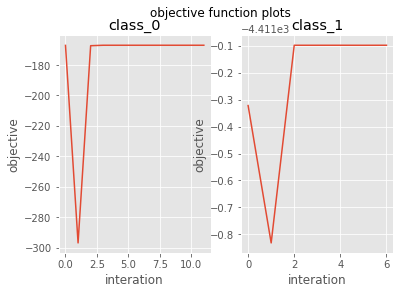

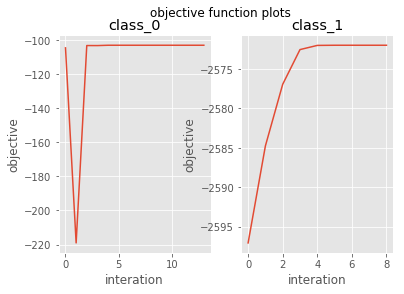

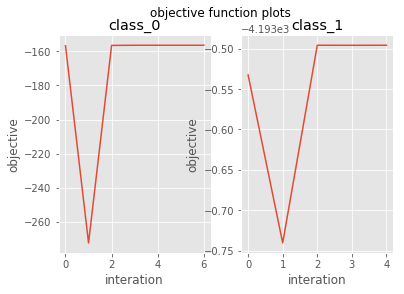

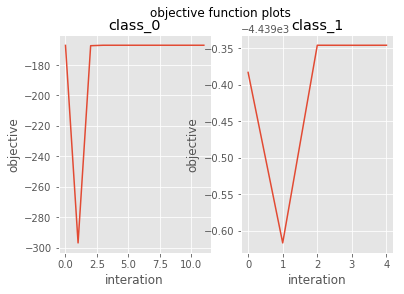

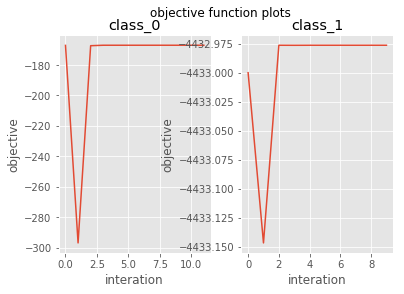

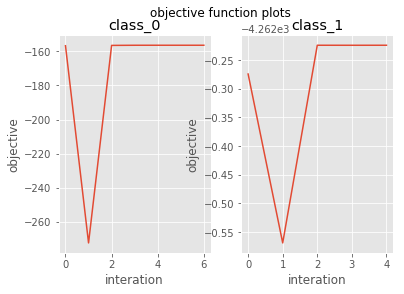

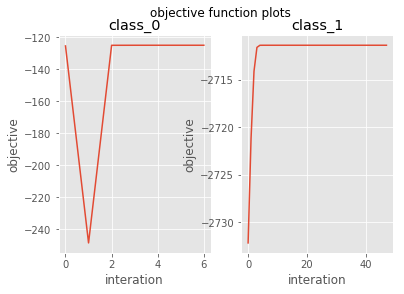

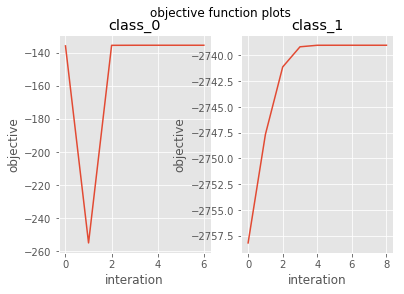

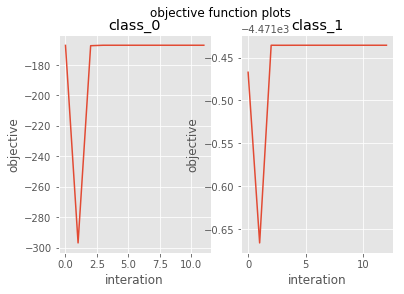

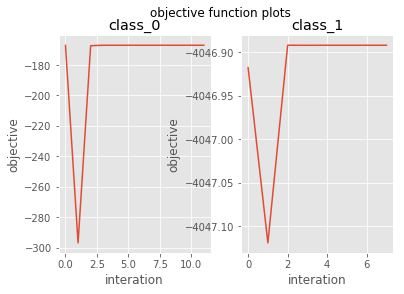

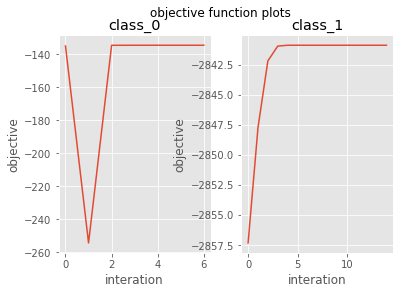

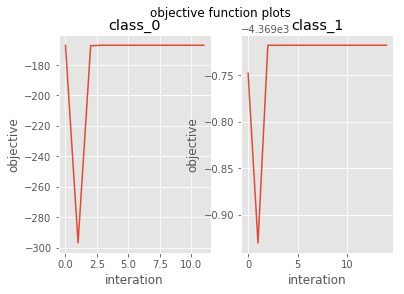

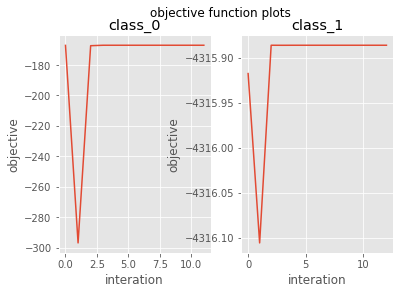

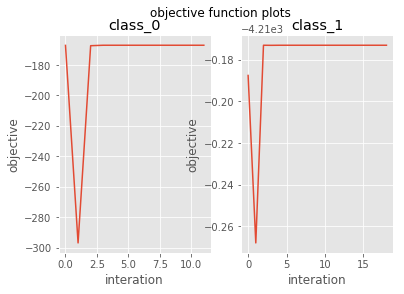

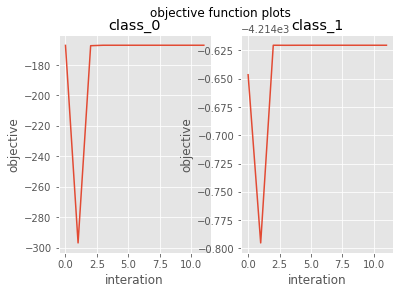

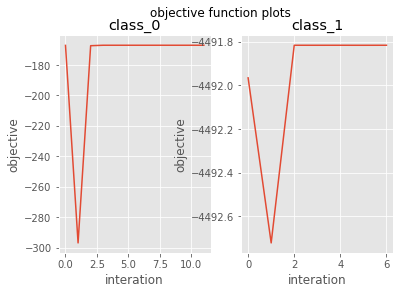

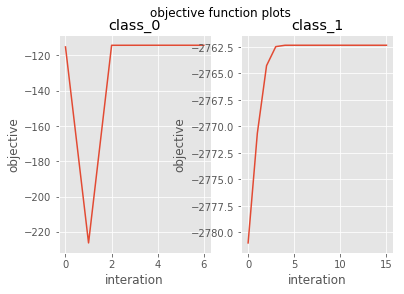

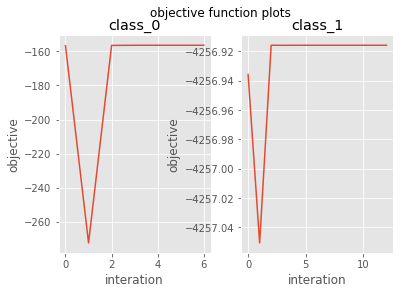

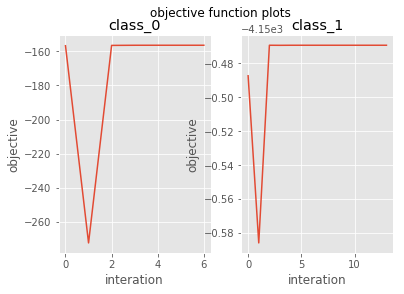

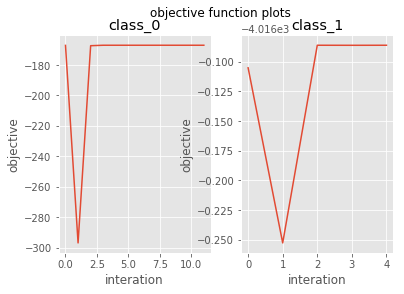

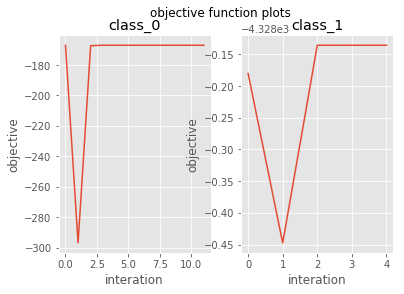

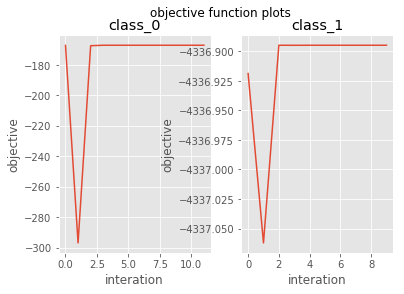

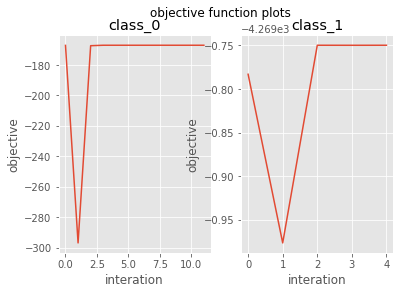

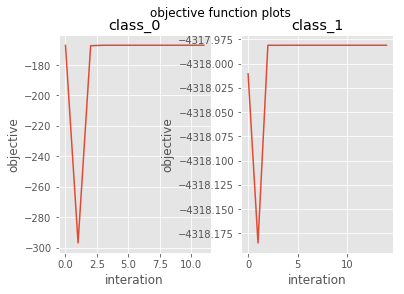

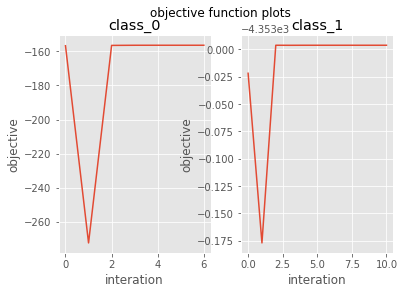

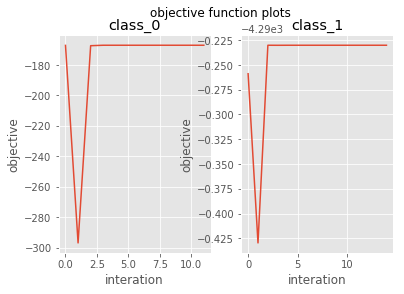

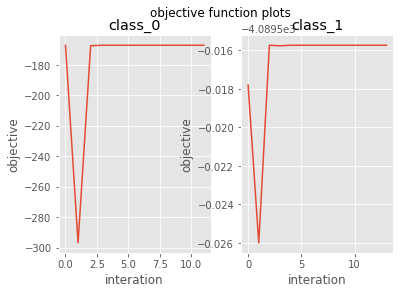

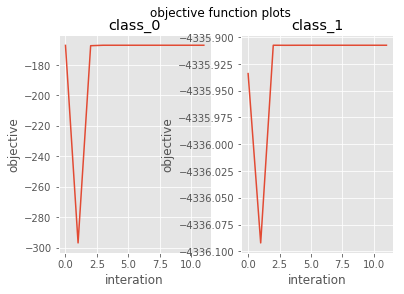

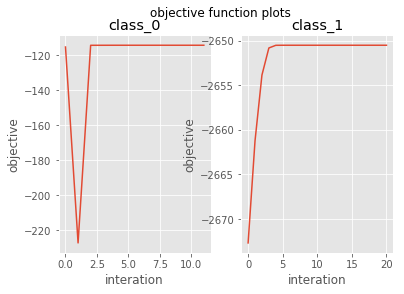

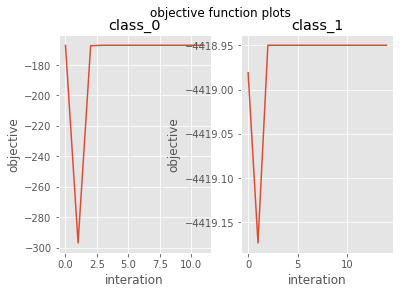

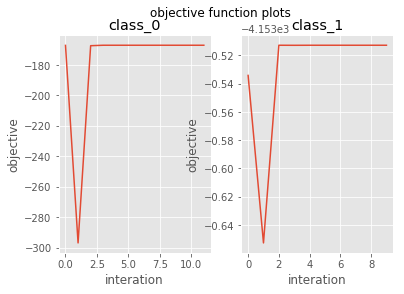

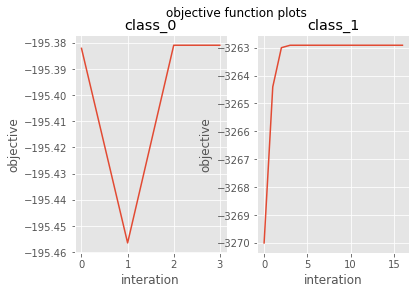

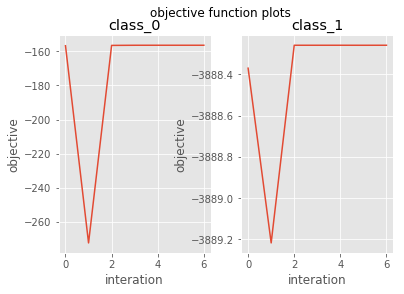

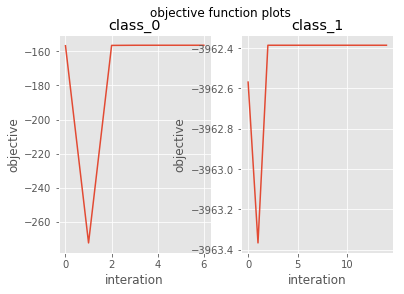

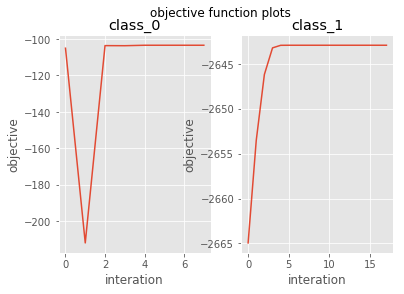

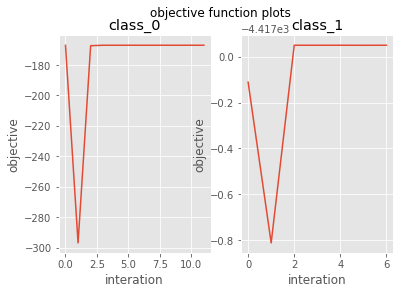

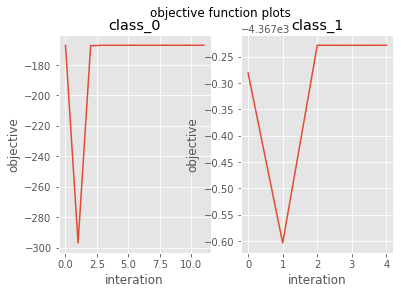

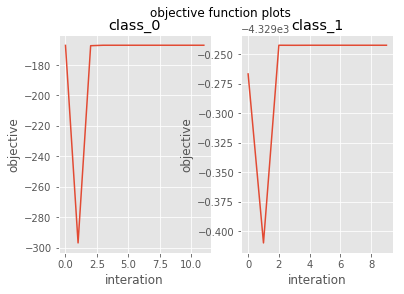

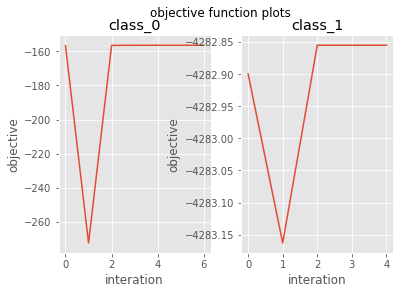

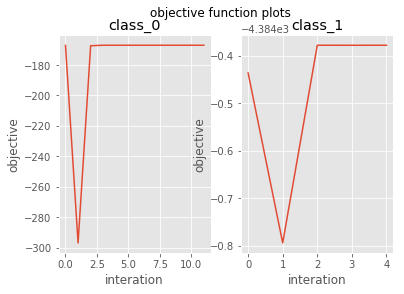

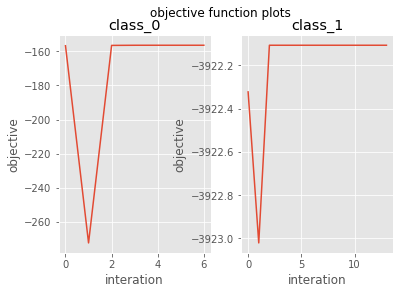

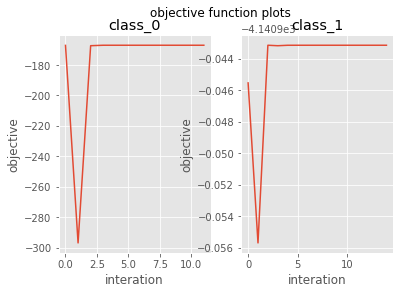

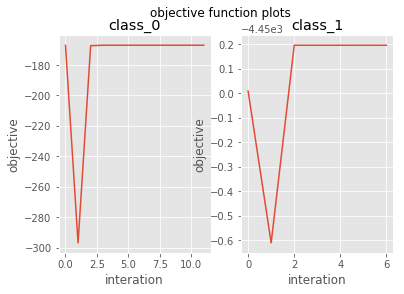

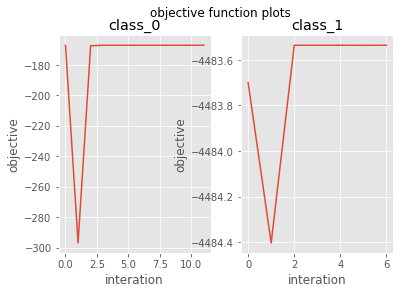

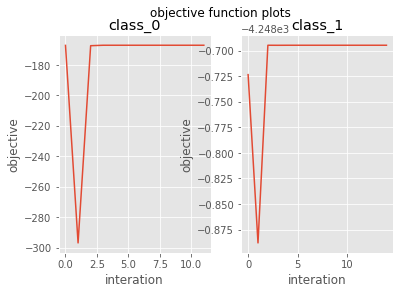

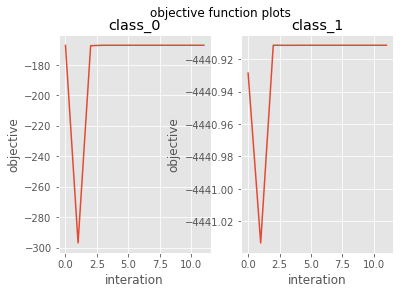

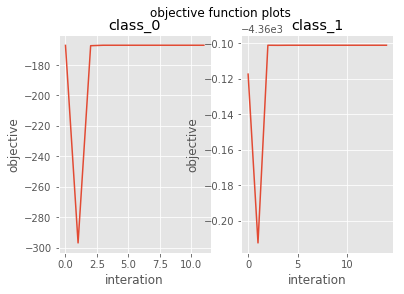

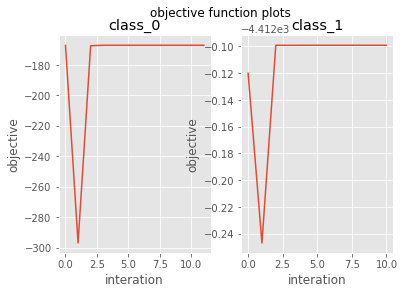

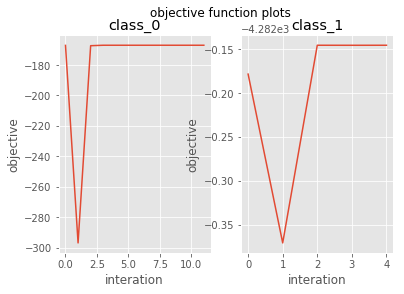

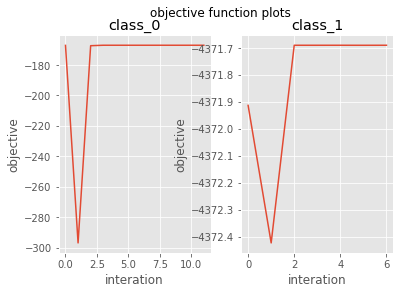

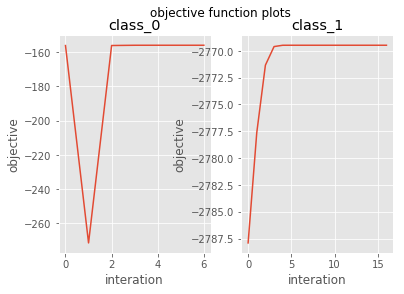

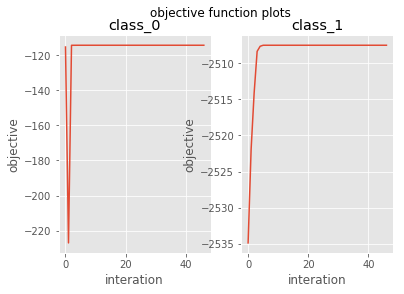

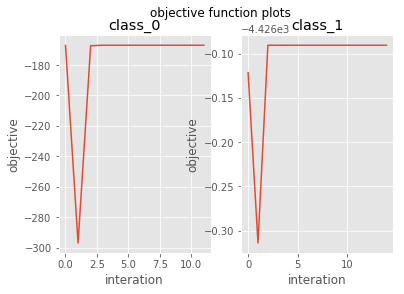

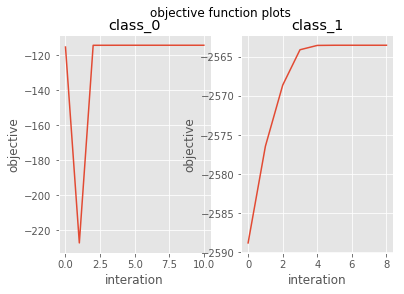

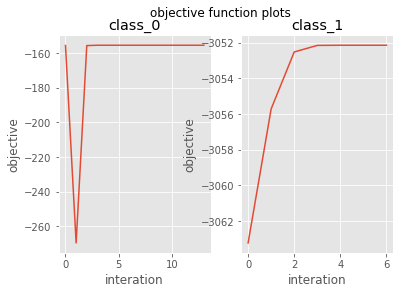

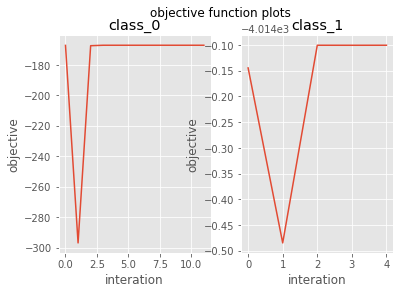

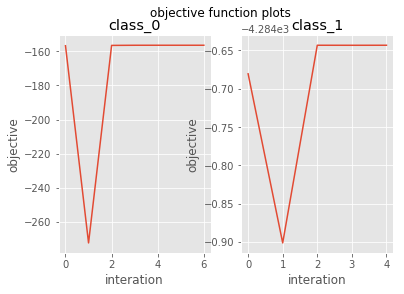

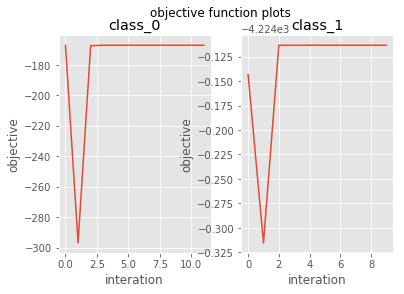

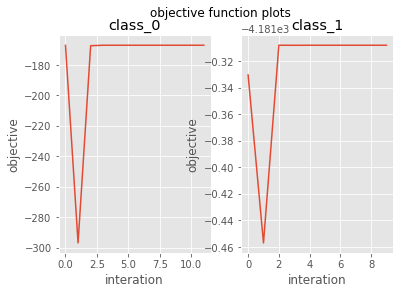

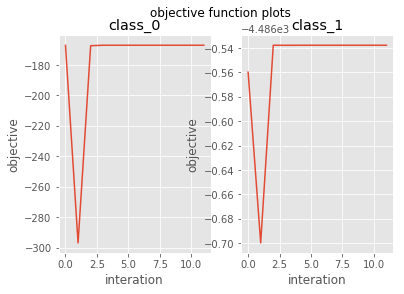

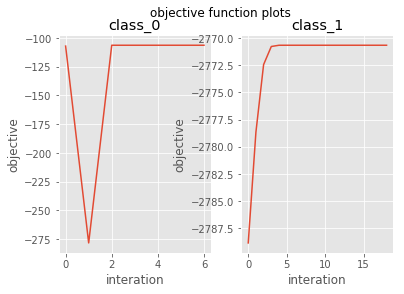

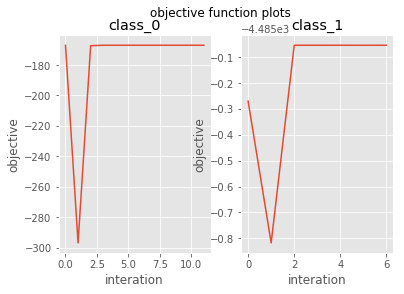

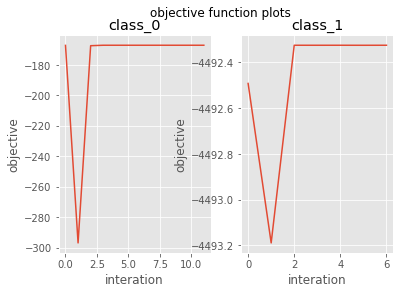

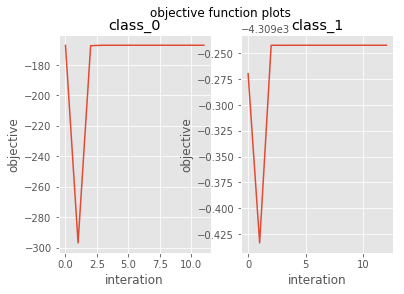

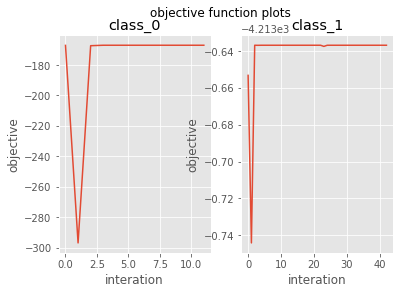

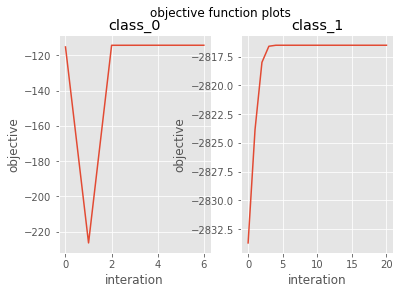

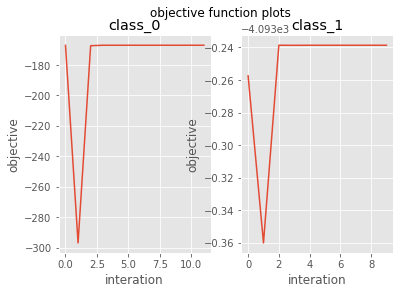

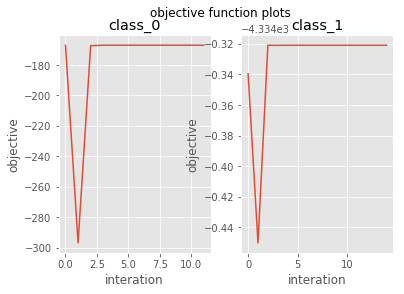

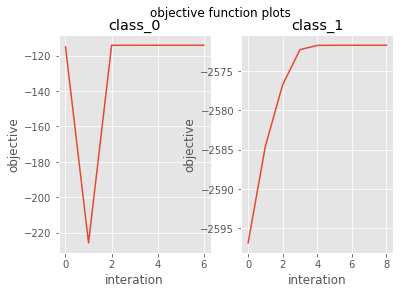

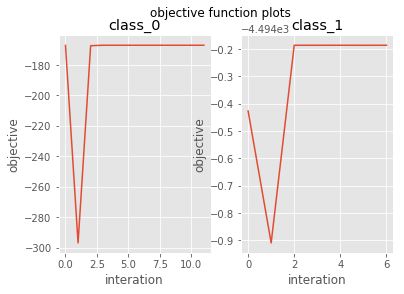

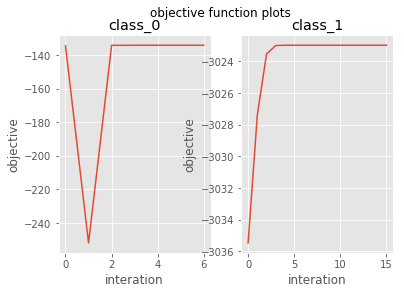

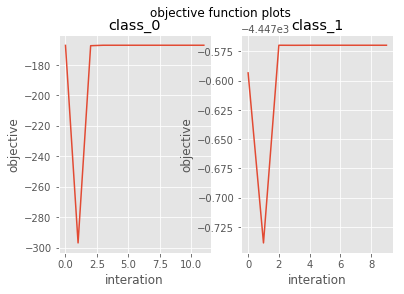

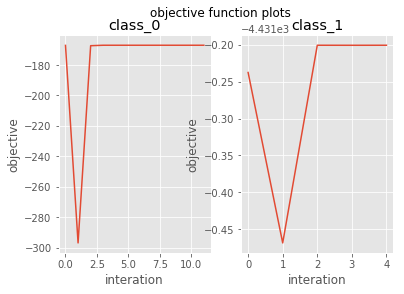

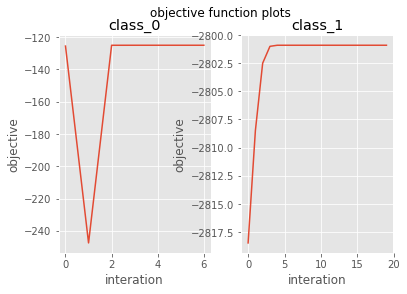

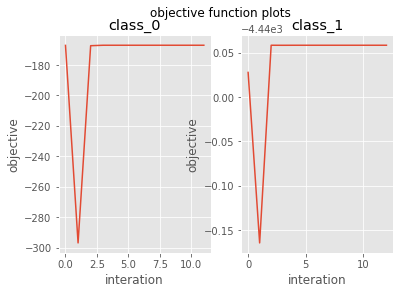

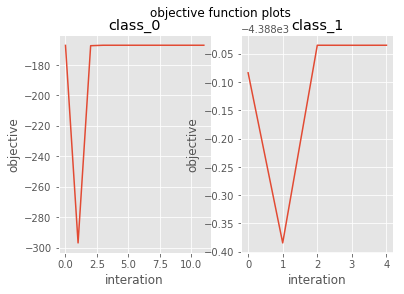

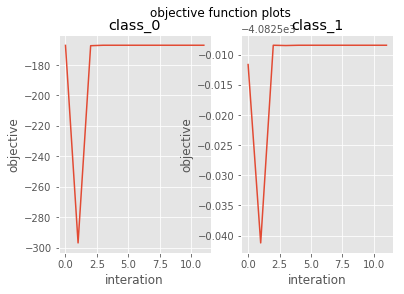

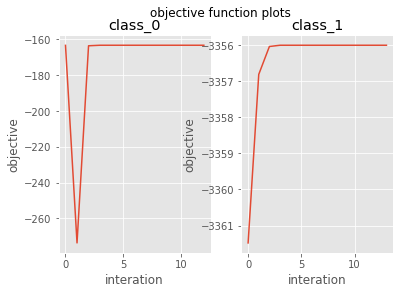

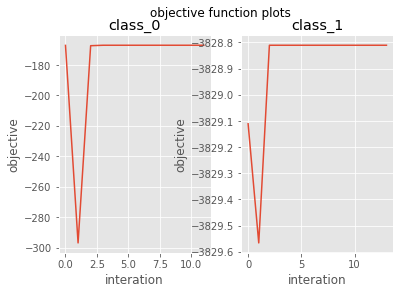

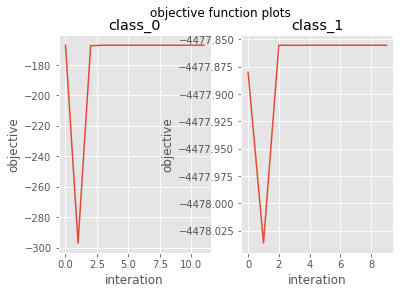

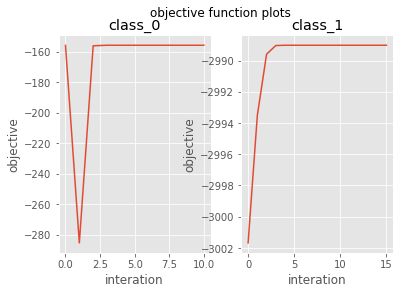

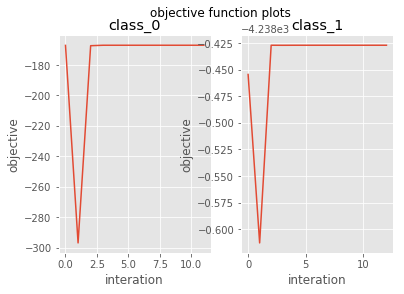

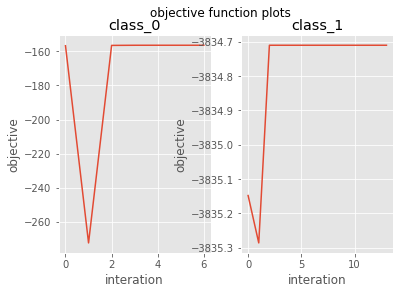

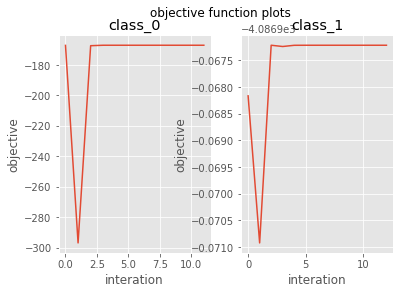

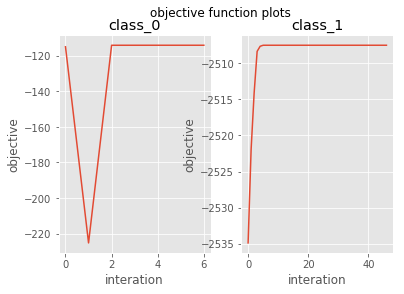

In [6]:
verbose = True
sample_name = []
y_true = []
y_pred = []
y_proba = [] # used to store positive-class posterior probability using posterior_c1 method
# y_proba_v2 = [] # used to test the method predict_proba

ref_proba_l = []
TCRs = count_df.drop(['sample_name','phenotype_status'],axis=1).columns.values # a list of TCR candidates
kf = LeaveOneOut()
for train_index,test_index in kf.split(train_origin): # for each cv round

    train = train_origin.copy(deep=True) # a copy of the original training data
    train_cv, test_cv = train.iloc[train_index], train.iloc[test_index] # get training samples and one testing sample

    # Select a list of associated TCRs based on count df of training samples and threshold
    count_train = count_df[count_df['sample_name'].isin(train_cv['sample_name'])] # count df of training samples
    count_test = count_df[count_df['sample_name'].isin(test_cv['sample_name'])] # count df of the testing sample

    TCRs_asso = TCRs_selection(count_train,TCRs,0.2) # select a list of TCRs

    '''
    Get statistics: number of phenotype_associated_TCRs of each sample
    '''
    # training set
    train_sample = train_cv['sample_name'].tolist()
    train_asso = []
    for i in range(len(train_sample)): # for each training sample

        temp_train = count_train.loc[count_train.sample_name==train_sample[i]] # count df of the training sample
        i_asso = np.count_nonzero(temp_train[TCRs_asso].values) # count the number of phenotype_associated TCRs in this sample
        train_asso.append(i_asso)

    train_cv['phenotype_associated_TCRs'] = train_asso # add the 'phenotype_associated_TCRs' column to the training data


    # testing set, the same steps as the above
    test_sample = test_cv['sample_name'].tolist()
    test_asso = []
    for i in range(len(test_sample)): # for each testing sample (in LOOCV, only one)

        temp_test = count_test.loc[count_test.sample_name==test_sample[i]]
        i_asso = np.count_nonzero(temp_test[TCRs_asso].values)
        test_asso.append(i_asso)

    test_cv['phenotype_associated_TCRs'] = test_asso

    '''
    Train the estimator, predict testing set (testing sample)
    '''
    # Initialize priors and perform MAP estimation
    neg_df = train_cv[train_cv['phenotype_status']==0]
    n_c0 = neg_df['unique_TCRs'].tolist()
    k_c0 = neg_df['phenotype_associated_TCRs'].tolist()

    pos_df = train_cv[train_cv['phenotype_status']==1]
    n_c1 = pos_df['unique_TCRs'].tolist()
    k_c1 = pos_df['phenotype_associated_TCRs'].tolist()
    
    def MAP_predict(train,test,prior_c0,prior_c1):
        '''
        Predicting testing set 
        '''
        MAP = MAP_estimator(prior_c0,prior_c1,obj_plot=True) # construct a MAP_estimator instance
        MAP.fit(train) # train the model using training set
#         if verbose == True:
#             print(MAP.priors()) # print the optimized priors
        priors = MAP.priors()
        print('After opt,priors:',priors)
        print('After opt, prior obj(class_0, class_1):',objective(priors[0],n_c0,k_c0),objective(priors[1],n_c1,k_c1))
        y_pred = MAP.predict(test)[0] # predict label of testing sample
        y_proba = MAP.predict_proba_c1(test)[0] # compute positive-class posterior probability
        # test_proba_v2 = MAP.predict_proba(test_cv,1)[0] # compute positive-class posterior probability by predict_proba method

        return y_pred, y_proba
    
    priors_init_value = prior_init(train_cv)
    prior_c0 = priors_init_value[0] 
    prior_c1 = priors_init_value[1]
    
    test_pred, test_proba = MAP_predict(train_cv,test_cv,prior_c0,prior_c1)
    
    # append results to lists, round to 3 decimal points
    sample_name.append(test_cv['sample_name'].tolist()[0])
    y_true.append(test_cv['phenotype_status'].tolist()[0])
    y_pred.append(test_pred)
    y_proba.append(round(test_proba,3))
    # y_proba_v2.append(round(test_proba_v2,3))

    # Results of this round
    if verbose == True:
#         print('Length of associated TCRs in this round:',len(TCRs_asso))
#         print('test sample: ',test_cv['sample_name'].tolist()[0], ' unique_TCRs: ',test_cv['unique_TCRs'].tolist()[0],' associated_TCRs: ',i_asso)        
        # print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',test_pred,
        #     ' y_proba_c1: %.3f'%test_proba,' y_proba_c1_v2: %.3f'%test_proba_v2)
        print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',test_pred,
            ' y_proba_c1: %.3f'%test_proba)
        
        print('\nReference:')
        
        ref_c0 = ref[0]
        ref_c1 = ref[1]
        MAP = MAP_estimator(ref_c0,ref_c1) # construct a MAP_estimator instance
        MAP.fit(train_cv) # train the model using training set
        ref_priors = MAP.priors()
        
        ref_pred = MAP.predict(test_cv)[0] # predict label of testing sample
        ref_proba = MAP.predict_proba_c1(test_cv)[0] # compute positive-class posterior probability
        ref_proba_l.append(ref_proba)
        print('prior_init obj:',objective(ref_c0,n_c0,k_c0),objective(ref_c1,n_c1,k_c1))
        print('After opt, priors:',ref_priors,'\nAfter opt, c0 obj:',objective(ref_priors[0],n_c0,k_c0),'c0 obj:',objective(ref_priors[1],n_c1,k_c1))
        print('y_true:',test_cv['phenotype_status'].tolist()[0],' y_pred:',ref_pred,
            ' y_proba_c1: %.3f'%ref_proba)
        print('*'*80)

print('cv auroc:',roc_auc_score(y_true,y_proba))
print('cv log_loss:',log_loss(y_true,y_proba))

print('\nReference:')
print('cv auroc:',roc_auc_score(y_true,ref_proba_l))
print('cv log_loss:',log_loss(y_true,ref_proba_l))
print()